# Machine Learning prediction of heatwaves
**Alessandro Lovo and George Miloshevich**

*To see equations in this file you may need Markdown Math extension on your vs code for example...*

If you are running on google colab set `colab = True`

In [1]:
colab = False

In [2]:
if colab:
    !pip install cartopy optuna nc-time-axis

import numpy as np
import pandas as pd
import xarray as xr
import os
from pathlib import Path

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


## Useful functions

A list of functions which will simplify your life in this assignment. You can look at the source code but it is not required in the interest of dedicating time to more intersting tasks

In [3]:
def Greenwich2Bering(xa:xr.DataArray):
    xa_ = xa.roll(lon=64, roll_coords=True) # rolling by 180 degrees
    xa_ = xa_.assign_coords({'lon': (xa_.lon + 180) % 360 - 180}) # keep the longitude monotonically increasing, useful for the plots
    return xa_


#### masked average of a field ####

def masked_average(xa:xr.DataArray,
                   dim=None,
                   weights:xr.DataArray=None,
                   mask:xr.DataArray=None) -> xr.DataArray:
    '''
    Computes the average of `xa` over given dimensions `dim`, weighting with `weights` and masking with `mask`

    Parameters
    ----------
    xa : xr.DataArray
        data
    dim : str or list of str, optional
        dimensions over which to perform the average, by default None
    weights : xr.DataArray, optional
        weights for the average, for example the cell, by default None
    mask : xr.DataArray, optional
        True over the data to keep, False over the data to ignore, by default None

    Returns
    -------
    xr.DataArray
        masked and averaged array
    '''
    #lest make a copy of the xa
    xa_copy = xa.copy()

    if mask is not None:
        xa_weighted_average = __weighted_average_with_mask(
            dim, mask, weights, xa, xa_copy
        )
    elif weights is not None:
        xa_weighted_average = __weighted_average(
            dim, weights, xa, xa_copy
        )
    else:
        xa_weighted_average =  xa.mean(dim)

    return xa_weighted_average


def __weighted_average(dim, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
    x_times_w = xa_copy * weights_all_dims
    xw_sum = x_times_w.sum(dim)
    x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
    xa_weighted_average = xw_sum / x_tot
    return xa_weighted_average


def __weighted_average_with_mask(dim, mask, weights, xa, xa_copy):
    '''helper function for masked_average'''
    _, mask_all_dims = xr.broadcast(xa, mask)  # broadcast to all dims
    xa_copy = xa_copy.where(mask)
    if weights is not None:
        _, weights_all_dims = xr.broadcast(xa, weights)  # broadcast to all dims
        weights_all_dims = weights_all_dims.where(mask_all_dims)
        x_times_w = xa_copy * weights_all_dims
        xw_sum = x_times_w.sum(dim=dim)
        x_tot = weights_all_dims.where(xa_copy.notnull()).sum(dim=dim)
        xa_weighted_average = xw_sum / x_tot
    else:
        xa_weighted_average = xa_copy.mean(dim)
    return xa_weighted_average

---
# Data

## 1.) Fetch the data

### If you are working on colab ignore this section

### If you are working locally you have two options:

1. Download the data from this google drive link:
https://drive.google.com/drive/folders/11xbAuZrOg-JVUKDFO2qRcUtZo11rc_Sq?usp=sharing
Then put it in a `data` directory which sits in the same folder as this notebook.

2. Execute the following two cells, which will automatically download the data and put it in the proper directory, however this may be slower than the previous option.
You also need to have `wget` installed on your machine

In [4]:
data_info_dict = {
    "mrso10": {
        "link": "https://mycore.core-cloud.net/index.php/s/r9XRFyOQgmsAvNG/download",
        "description": "10 days of soil moisture data on the whole globe. Just an example"
    },
    "mrso": {
        "link": "https://mycore.core-cloud.net/index.php/s/qfIuHHrcaBopDvG/download",
        "description": "500 years of soil moisture data for latitudes >= 30 degrees North."
    },
    "tas": {
        "link": "https://mycore.core-cloud.net/index.php/s/KILq90d1y3wsoHc/download",
        "description": "500 years of surface temperature data for latitudes >= 30 degrees North."
    },
    "zg500": {
        "link": "https://mycore.core-cloud.net/index.php/s/ClD58tHT9Odtxbh/download",
        "description": "500 years of geopotential height at 500 hPa data for latitudes >= 30 degrees North."
    },
    "lsmask": {
        "link": "https://mycore.core-cloud.net/index.php/s/qMCVdDzgoowomzV/download",
        "description": "Land (1) - sea (0) mask on the whole globe"
    },
    "gparea": {
        "link": "https://mycore.core-cloud.net/index.php/s/i5sP7DexJY1RFaK/download",
        "description": "Area of each grid cell for the whole globe"
    },
}


def fetch(name, destination='./data', reload=False):
    destination = Path(destination).resolve()
    if not os.path.exists(destination):
        destination.mkdir(parents=True)

    if name.endswith('.nc'):
        name = name[:-3]

    file = destination / f'{name}.nc'
    if not os.path.exists(file) or reload:
        try:
            link = data_info_dict[name]['link']
        except KeyError:
            raise KeyError(f'No item {name} in data_info.json')
        os.system(f"wget -O {file} \"{link}\"")
    else:
        print(f'{name}: file already downloaded')

In [6]:
reload_file = False

fetch('mrso', reload=reload_file)
fetch('tas', reload=reload_file)
fetch('zg500', reload=reload_file)
fetch('lsmask', reload=reload_file)
fetch('gparea', reload=reload_file)

mrso: file already loaded
tas: file already loaded
zg500: file already loaded
lsmask: file already loaded
gparea: file already loaded


---

## Working with climate data

The data consists of three fields (we have subtracted the climatology for you):
* `mrso`: soil moisture anomaly 
* `tas`: 2 meter temperature anomaly (not to be confused with surface temperature). It would be more appropriate to refer to it as t2m, but due to historical reasons we call it here tas
* `zg500`: geopotential height at 500 hPa anomaly

These fields are sampled for latitudes above 30 degrees north with a resolution of 2.8 degrees both in latitude and longitude.  
The model used to produce this data considers the year to be composed of 12 months, 30 days each (360 days year).  
The total length of the dataset we provide is 500 years of daily averages between the 1st of April and the 30th of August (120 days). This is just a fraction of the data (8000 years) we used for the upcoming paper, where extensive analysis of machine learning techniques is performed with that larger dataset

Also other two much smaller files are provided:
* `lsmask`: land sea mask with value 1 on land and 0 at sea.
* `gparea`: area of each grid cell

These two have the same resolution of the fields but are provided for the whole globe

--

We need to understand how the data looks, whether there are some outright anomalies. 

For example here we have a look at temperature data using `xarray`

In [ ]:
if colab:
    from google.colab import drive
    drive.mount('drive')
    data_path = 'drive/MyDrive/EW2-heatwaves/data'

else:
    data_path = './data'

In [5]:
ds_tas = xr.open_dataset(f"{data_path}/tas.nc")
ds_tas

<xarray.Dataset>
Dimensions:    (time: 60000, bnds: 2, lat: 22, lon: 128)
Coordinates:
  * time       (time) object 0001-05-01 10:30:00 ... 0500-08-30 10:30:00
  * lon        (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat        (lat) float64 87.86 85.1 82.31 79.53 ... 37.67 34.88 32.09 29.3
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds, lat) object ...
    tas        (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.0
    history:      Fri Oct 01 20:31:36 2021: cdo ydaysub /ClimateDynamics/Medi...
    title:        PUMA/PLASIM DATA
    frequency:    day
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [6]:
tas = ds_tas.tas

`ds_tas` is a `xr.Dataset` and `tas` is a `xr.DataArray` containing the field of interest, in this case surface temperature.

---
## 2.) Plasim data visualization
* Look at some overall statistics, mean, std, etc

    - zg500: 500 mbar geopotential
    - mrso: soil moisture

We can easily extract the time series for the first 4 months (first year) corresponding to the latitude = 15 and longitude = 1

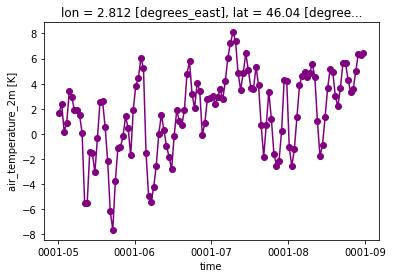

In [7]:
# first year
tas.isel(lat=15, lon=1, time=slice(0, 120)).plot.line(color='purple', marker='o')

The two meter temperature distribution

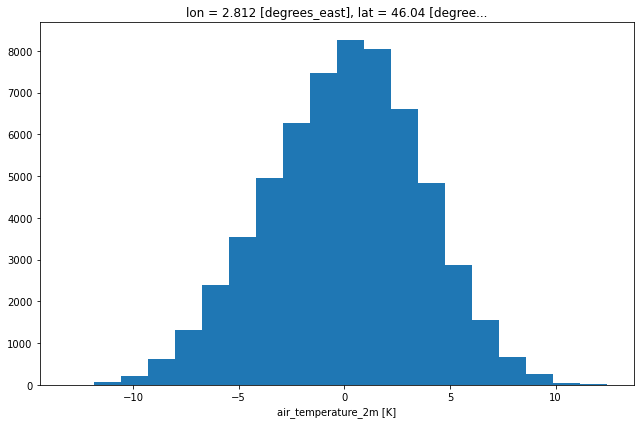

In [8]:
fig, ax = plt.subplots(figsize=(9,6))

tas.isel(lat=15, lon=1).plot.hist(ax=ax, bins=20)

fig.tight_layout()

Using cartopy we can plot 500 mbar geopotential over the north hemisphere. If you pay attention there is a hole along Greenwich meridian

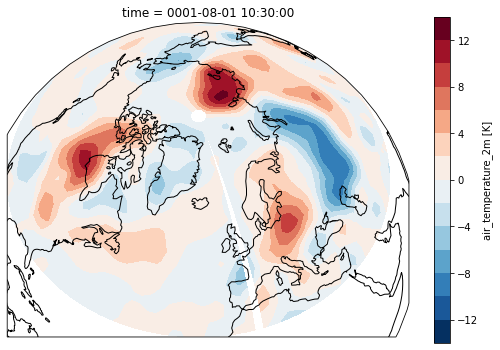

In [9]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.Orthographic(-20, 55))
# ax.set_global()
tas.isel(time=90).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=15)
ax.coastlines()

Let us move shift the data as to move the edges away from Europe: Let's put them over the Bering sea.

In [10]:
tas = Greenwich2Bering(tas) # careful to execute this line only once :)

The data was cut on 0 meridian simply due to convention (Rectangular grid of Plasim). But unless some complex padding strategies of padding were implemented, this hole would create problems for convolutional neural network. Also note that the 0 meridian goes through the area of interest France, and thus removing this local defect is important

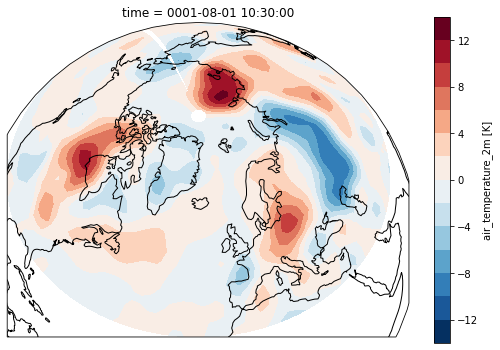

In [11]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.Orthographic(-20, 55))
# ax.set_global()
tas.isel(time=90).plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=15)
ax.coastlines()

Below we compute standard deviation with respect to time to have an idea about how much the temperature fluctuates and how this is distributed

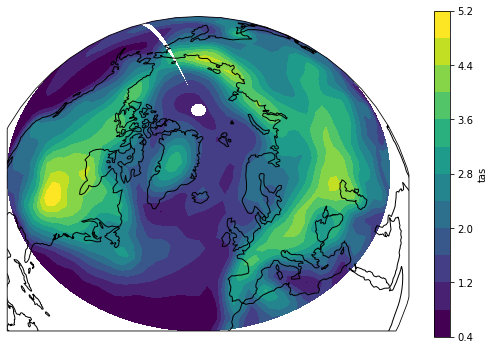

In [12]:
fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.Orthographic(-20, 55))
# ax.set_global()
tas.std('time').plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=15)
ax.coastlines()

---
## 3.) Area integrals
* Define the area of France (or some other place)
$$
\alpha(t):=\frac{1}{|\mathcal{D}|} \int_{D}\left(T_{2m}-\mathbb{E}\left(T_{2m}\right)\right)(\vec{r}, u) \mathrm{d} \vec{r} \mathrm{~d} u
$$
* Compute area intregrals
* Look at the time series, statistics, mean, std
* Compute the running mean of T-days (T=14 days)
    $$
        A(t):=\frac{1}{T} \int_{t}^{t+T} \alpha(t)  
    $$

Now let us define a region of interest. We need two additional objects: `gparea` which gives us the area of each grid cell and `lsmask` which is land-sea mask (it tells us where the continents are). We must also ``roll`` the mask and the area.

In [13]:
gparea = xr.open_dataset('data/gparea.nc').cell_area # cell area
lsmask = xr.open_dataset('data/lsmask.nc').lsm # land sea mask

# roll the longitude
gparea = Greenwich2Bering(gparea)
lsmask = Greenwich2Bering(lsmask)

land_area = gparea*lsmask # 0 over sea, land area over land

Now we can specify area we define as France. This grid is quite large so the actual political borders may not be respected, however this is not relevant for the exercise. The point is to work with the area that is large enough on synoptic scales, in a region where coupling to soil is significant. For instance, in Scandinavia heat waves are not correlated with soil moisture deficits

<xarray.DataArray ()>
array(16)


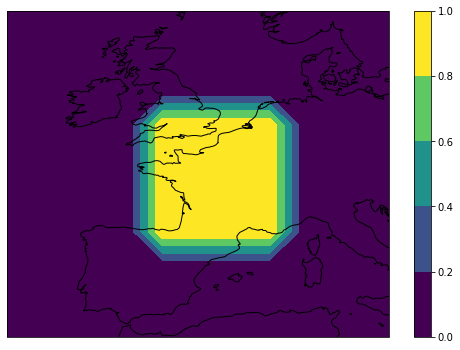

In [14]:
mask = xr.where((lsmask.lat > 42)*(lsmask.lat < 52)*(lsmask.lon < 8)*(lsmask.lon > -5), 1, 0)
print(mask.sum())

fig = plt.figure(figsize=(9,6))

ax = fig.add_subplot(projection=ccrs.PlateCarree())
mask.plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.coastlines()
ax.set_extent([-15, 15, 35, 60])

Let's compute area mean weighted by grid size and land sea mask. This operation may take some time

In [15]:
mask_avg = masked_average(tas, dim=['lat','lon'], weights=land_area, mask=mask)

The following uses iwdigets, which allows interactive plotting. You may need the required packages listed in readme.md. If the problems persist you may comment the first line

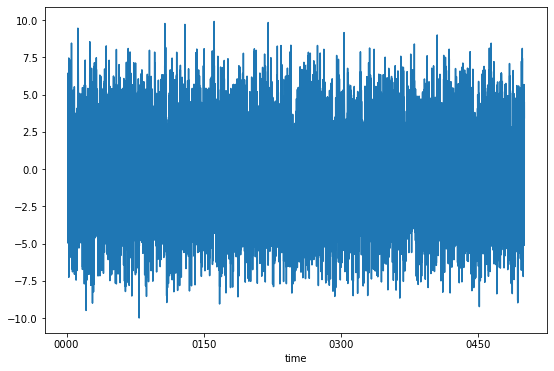

In [16]:
#%matplotlib widget
fig, ax = plt.subplots(figsize=(9,6))

mask_avg.plot(ax = ax)

Now we compute the forward 14 day convolution

In [23]:
T = 14

def t_avg(xa):
    av = xa[::-1].rolling(time=T, center=False).mean().dropna('time') # we work on the reversed array so we have the forward T day rolling mean
    return av[::-1]

A = (mask_avg.groupby('time.year').apply(t_avg)) # we treat each year separately
A

<xarray.DataArray (time: 53500)>
array([ 0.16281547, -0.0755511 , -0.20284986, ...,  0.40830513,
        0.22922166,  0.23792203])
Coordinates:
  * time     (time) object 0001-05-01 10:30:00 ... 0500-08-17 10:30:00

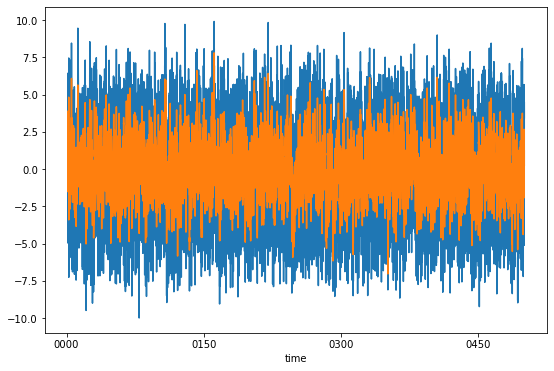

In [19]:
fig, ax = plt.subplots(figsize=(9,6))

mask_avg.plot(ax = ax)
A.plot(ax=ax)

## Define the labels 
* Define heat wave labels (Choose 95 percentile of $A(t)$ for example)

In [20]:
threshold = 2.78

Y = A > threshold
Y.sum()/len(Y)

<xarray.DataArray ()>
array(0.05863551)

#### We can better define the threshold as a percentile of the data

In [21]:
# get the array of A values as np array
np_A = np.array(A.variable)
np_A = np.sort(np_A)

threshold = np_A[int(0.95*len(np_A))]
print(threshold)

Y = A > threshold
Y.sum()/len(Y)

2.925672981009553


<xarray.DataArray ()>
array(0.04998131)

---

# Machine Learning

This is the exercize that students are supposed to work on with some help from these notes but more indepdently than the previous assignments, that involved basically ``run this script`` instructions

### Evaluating Performance

How do we know that the statistical model has learned the weights well?

* Familiarize yourself with skill scores

    - Brier score. Popular in meteorology
        $$ 
            S=\frac{1}{2}\sum_{k=0}^{K-1}\left[\delta_{Y,k}-\hat{p}_{k}(X)\right]^{2}
        $$
    - Logarithmic score. More applicable to rare events and machine learning friendly. Also, conveniently, it corresponds to the binary cross-entropy which is exactly what a neural network would minimize
        $$
            -S\left[\hat{p}_{Y_{n}}(X_{n})\right]=-Y_{n}\log\left[\hat{p}_{Y_{n}}(X_{n})\right]-\left(1-Y_{n}\right)\log\left[1-\hat{p}_{Y_{n}}(X_{n})\right].
        $$
        
    -   [Matthew's Correlation Coefficient](https://en.wikipedia.org/wiki/Phi_coefficient). Useful when threshold is chosen for assigning the event. You can read the [wikipedia link](https://en.wikipedia.org/wiki/Phi_coefficient) provided or consult some textbooks.
        $$
            \mathrm{MCC}=\frac{T P \times T N-F P \times F N}{\sqrt{(T P+F P)(T P+F N)(T N+F P)(T N+F N)}}
        $$
* The goal is to predict labels and evaluate performance using MCC

``` The exercise on simple classifier might be too much for students to do. Maybe we should evaluate if they have anough time, since neural network is more important, so consider it as optional. On the other hand they can quickly get their hands on simple models and verificiation ```
## 4.) Simple classifier (OPTIONAL)
Before trying something complex always resort to good-old techniques to see what can be achieved without much effort
* Perform train-validation-test 
* Try undersampling the negative labels to accelerate learning and save some RAM
* Logistic regression, Naive Bayes, kNN, etc
* See what can be achieved with simple persistance
* Try using soil moisture or geopotential in the same spirit

---

# Neural networks

It is recommended that the students work with tensorflow. The tutorials are available here

## 5.) Convolutional Neural Network
* Design a simple CNN architecture with a dense layer and sigmoid/softmax output
* Start by providing input with 2-meter temperature, or geopotential (results will vary)
* Normalize the original data (try different ways)
* Put the data through the pipeline and train the network

---

# 6.) Hyperparameter optimization

* Implement early stopping to save time

### optimization using `optuna`

#### Example

In [24]:
import optuna

In [25]:
# define a function that takes as input a trial and returns a float

def objective(trial):
    # obtain a value for your hyperparameters using the functions `suggest_float`, `suggest_int` and `suggest_categorical`

                        # parameter name
                        #    |    bounds
    x = trial.suggest_float('x', -10, 10)
    y = trial.suggest_float('y', -10, 10)

    # compute the score related to the given hyperparameters:
    # i.e. build your network, train it and evaluate it on the validation set

    score = (x - 2)**2 + 0.1*y**2 # here we use a dummy score
    return score

study = optuna.create_study() # create a study

study.optimize(objective, n_trials=100,)


[I 2022-04-12 11:07:04,663] A new study created in memory with name: no-name-ebc20d26-7f30-41e2-9989-09d42797f510
[I 2022-04-12 11:07:04,668] Trial 0 finished with value: 81.60509107993867 and parameters: {'x': -6.597580732191808, 'y': -8.767380813779468}. Best is trial 0 with value: 81.60509107993867.
[I 2022-04-12 11:07:04,670] Trial 1 finished with value: 15.508354919611351 and parameters: {'x': -1.615734365959991, 'y': -4.934389439867159}. Best is trial 1 with value: 15.508354919611351.
[I 2022-04-12 11:07:04,681] Trial 2 finished with value: 111.3928347638206 and parameters: {'x': -8.509027868006791, 'y': 3.087341952679097}. Best is trial 1 with value: 15.508354919611351.
[I 2022-04-12 11:07:04,683] Trial 3 finished with value: 1.4292975827206529 and parameters: {'x': 1.0284572797488707, 'y': 2.2031847980768404}. Best is trial 3 with value: 1.4292975827206529.
[I 2022-04-12 11:07:04,684] Trial 4 finished with value: 44.671332965148586 and parameters: {'x': 8.518125585294737, 'y': 

In [26]:
study.best_trial.number, study.best_params

(98, {'x': 1.9123598393093062, 'y': -0.26507100220906543})

In [27]:
df = study.trials_dataframe()
df

number       value             datetime_start          datetime_complete  \
0        0   81.605091 2022-04-12 11:07:04.666776 2022-04-12 11:07:04.667648   
1        1   15.508355 2022-04-12 11:07:04.669218 2022-04-12 11:07:04.669691   
2        2  111.392835 2022-04-12 11:07:04.680941 2022-04-12 11:07:04.681388   
3        3    1.429298 2022-04-12 11:07:04.682385 2022-04-12 11:07:04.682860   
4        4   44.671333 2022-04-12 11:07:04.683887 2022-04-12 11:07:04.684409   
..     ...         ...                        ...                        ...   
95      95    0.566335 2022-04-12 11:07:06.155929 2022-04-12 11:07:06.166338   
96      96    3.832582 2022-04-12 11:07:06.169549 2022-04-12 11:07:06.179755   
97      97    0.832963 2022-04-12 11:07:06.182876 2022-04-12 11:07:06.193251   
98      98    0.014707 2022-04-12 11:07:06.196337 2022-04-12 11:07:06.206855   
99      99    0.097628 2022-04-12 11:07:06.209970 2022-04-12 11:07:06.220373   

                 duration  params_x  params_y     state  
0  0 days 00:00:00.000872 -6.597581 -8.767381  COMPLETE  
1  0 days 00:00:00.000473 -1.615734 -4.934389  COMPLETE  
2  0 days 00:00:00.000447 -8.509028  3.087342  COMPLETE  
3  0 days 00:00:00.000475  1.028457  2.203185  COMPLETE  
4  0 days 00:00:00.000522  8.518126  4.674796  COMPLETE  
..                    ...       ...       ...       ...  
95 0 days 00:00:00.010409  1.295437 -0.836221  COMPLETE  
96 0 days 00:00:00.010206  3.957038 -0.160808  COMPLETE  
97 0 days 00:00:00.010375  2.883312  0.726110  COMPLETE  
98 0 days 00:00:00.010518  1.912360 -0.265071  COMPLETE  
99 0 days 00:00:00.010403  1.692961 -0.183172  COMPLETE  

[100 rows x 8 columns]

#### Optuna has several nice tools for visualization of the hyperparameter optimization

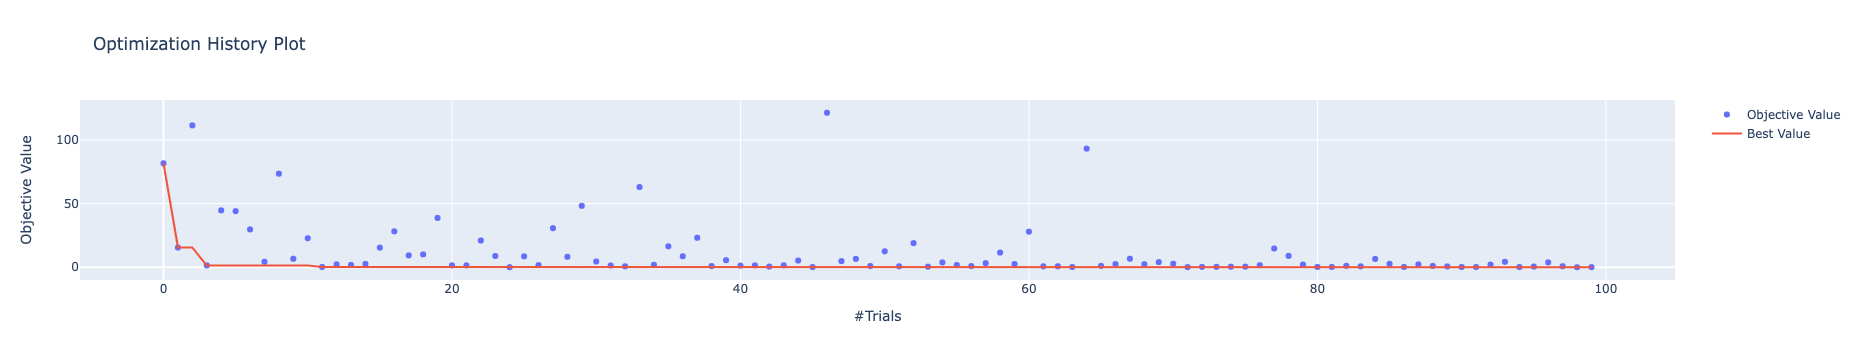

In [28]:
optuna.visualization.plot_optimization_history(study)

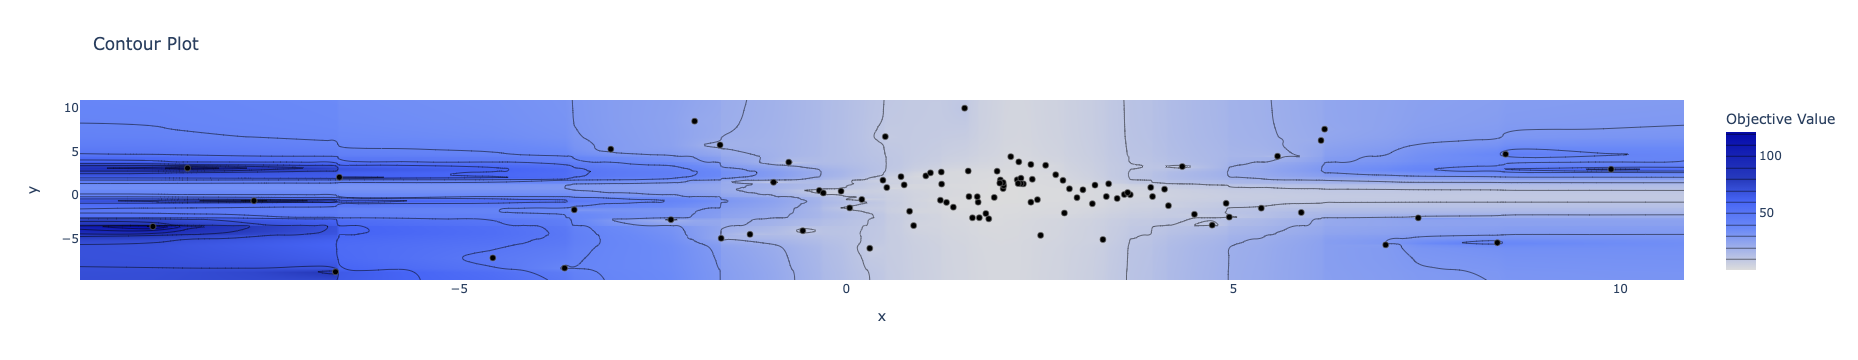

In [29]:
fig = optuna.visualization.plot_contour(study, params=['x', 'y'])
fig.show()

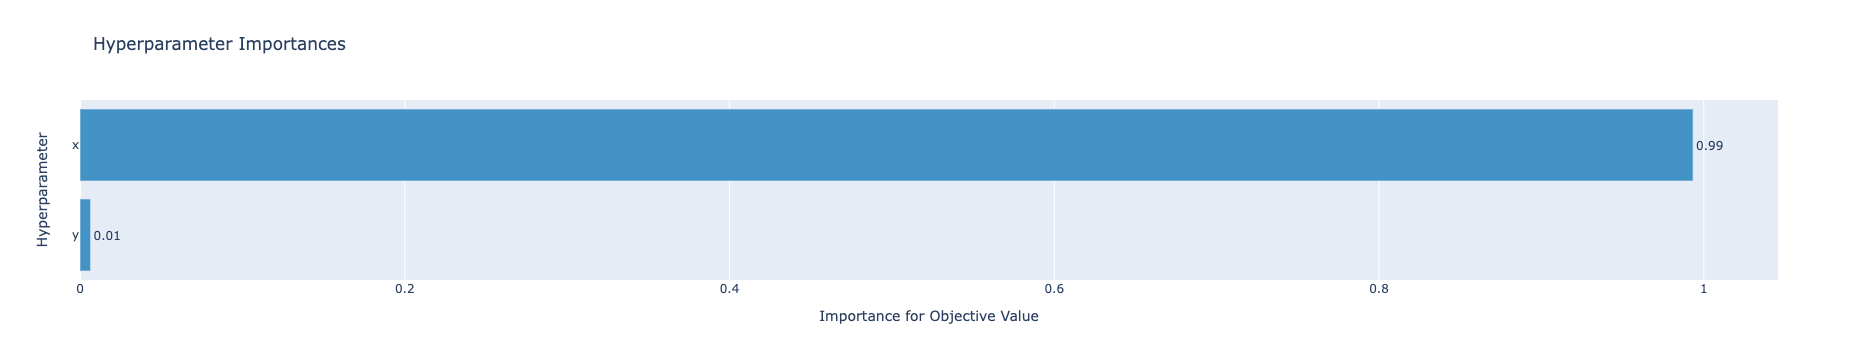

In [30]:
optuna.visualization.plot_param_importances(study)